In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt
import cspsa
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize


In [ ]:
from my_modulemati import Mean_Direct_Fidelity

### Initial Parameters

In [ ]:
NQs = np.array([3])
L = len(NQs)
N = 3
shots = 10_000
simulator_ideal=Estimator(backend_options={'shots':shots,},
                              transpile_options={'optimization_level':0} ) 
n_jobs = -1




In [ ]:
from joblib import Parallel, delayed

def simulate(NQ, j,simulator):
    MDF = Mean_Direct_Fidelity(NQ)
    MDFT = Mean_Direct_Fidelity(NQ)
    Fidelities = []
    Measures = []
    FidelitiesT = []
    MeasuresT = []
    Last=[]
    LastT=[]
    d=2**NQ
    
    
    Omega = QuantumCircuit(NQ)
    Omega.h(0)
    for a in range(NQ-1):
        Omega.cx(a, a+1)

    OmegaM=np.outer(np.array(Statevector(Omega)),(np.array(Statevector(Omega))).conj()) 


    f=lambda x: np.vdot(x, OmegaM@x)/(np.linalg.norm( x ))**2

    psi0 = np.random.rand(d) + 1j * np.random.rand(d)
    psi0 = psi0 / np.linalg.norm(psi0)
    guess = psi0
    def callback0( i, x ):
        Last.append(x)
        Fidelities.append(f(x))
        Measures.append(len(MDF.Measures))
        return None
    def callback0T( i, x ):
        LastT.append(x)
        FidelitiesT.append(f(x))
        MeasuresT.append(len(MDFT.Measures))
        return None
    I = lambda x: (1 - MDF.MeanFidelity(1, 2*NQ**3, x/np.linalg.norm(x), Omega,
                                         estimator=simulator, shots=10000, truncation=False))**2
    IT = lambda x: (1 - MDFT.MeanFidelity(1, 2*NQ**3, x/np.linalg.norm(x), Omega,
                                          estimator=simulator, shots=10000, truncation=True))**2
    
    optimizer = cspsa.SPSA(init_iter=200, callback=callback0)
    optimizerT = cspsa.SPSA(init_iter=200, callback=callback0T)
    
    optimizer.run(I, guess, progressbar=False, num_iter=100)
    optimizerT.run(IT, guess, progressbar=False, num_iter=100)
    Results=[np.array(Fidelities),
                      np.array(Measures),
                      np.array(FidelitiesT),
                      np.array(MeasuresT),
                      ]
    
    
    def min(phi,M_d):
        phi = phi / np.linalg.norm(phi)
        def CostF(psi,M_d):  
            M=MDF.Chi(psi,truncation=False)
            f=0
            for j, _ in enumerate( M ):
                if j in M_d:
                    f += np.sum( np.abs( M_d[j] - M[j] ) )
                else:
                    f += 0.1*np.sum( np.abs( M[j] ) )
            return f 

        results = minimize( CostF, phi, args=(M_d) )
        psi_hat = results.x / np.linalg.norm(results.x )
        return psi_hat

    

    f0=f(min(Last[-1],MDF.Measures))
    
    
    f1=f(min(LastT[-1],MDFT.Measures))
    
    F=[f0,f1]       
    return {j:Results},{j: F} #j index the average over the Hilbert space



In [ ]:
from itertools import chain
R = []
F = []
# Iterar sobre cada valor en NQs
for NQ in NQs:
    Data0=[]
    Data1=[]
    for r, ff in Parallel(n_jobs=n_jobs, verbose=11)(
        delayed(simulate)(NQ, j,simulator_ideal) for j in range(N)):
        Data0.append(r)
        Data1.append(ff)
    
    R.append(Data0)
    F.append(Data1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.7s finished


In [ ]:
from itertools import chain
RD=[{} for _ in range(L)]
FD=[{} for _ in range(L)]
for j in range(L): 
    RD[j]=dict(chain.from_iterable(dic.items() for dic in R[j])) 
for j in range(L): 
    FD[j]=dict(chain.from_iterable(dic.items() for dic in F[j])) 
    

In [ ]:

Promedio=[]
PromedioF=[]
for i in range(L):
    Promedio.append(sum(np.array(RD[i][a]) for a in range(N))/N)
    PromedioF.append(sum(np.array(FD[i][a]) for a in range(N))/N)


In [ ]:
PromedioF[0]

array([0.5009798 +8.89045781e-18j, 0.52193328+0.00000000e+00j])

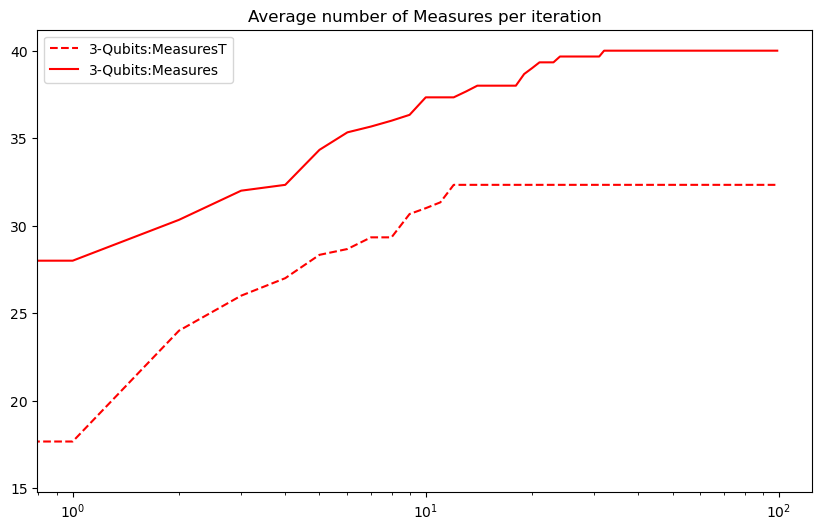

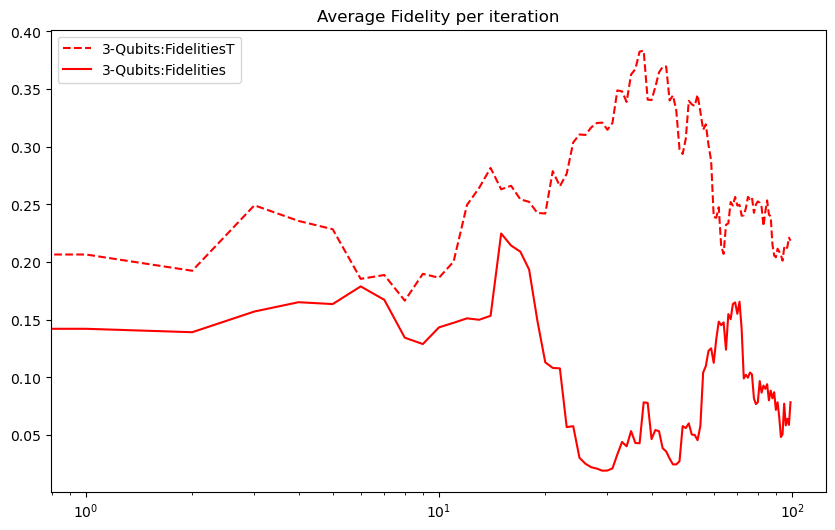

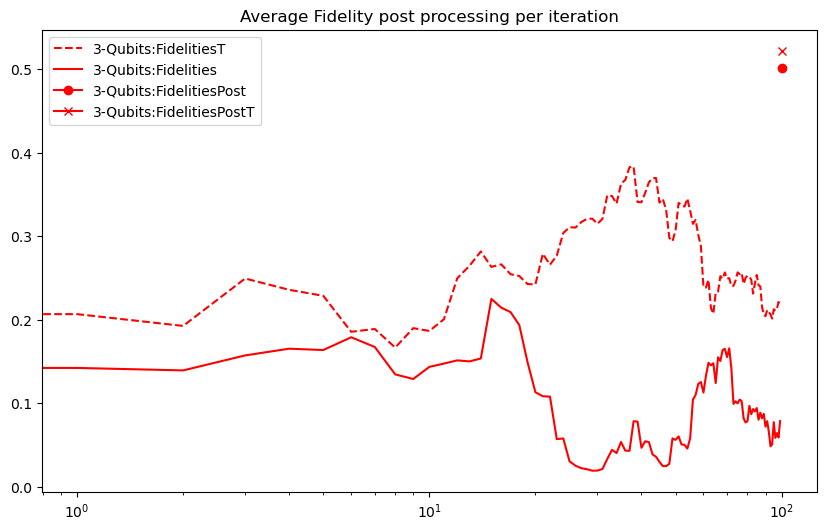

In [ ]:

import matplotlib.pyplot as plt

# Lista de colores arbitrarios
colores = ['r', 'g', 'b', 'orange', 'purple']

# Crear primer conjunto de gráficos para Measures
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_title('Average number of Measures per iteration')

for j in range(len(NQs)):
    ax1.semilogx(Promedio[j][3], label=f'{NQs[j]}-Qubits:MeasuresT', linestyle='--', color=colores[j])
    ax1.semilogx(Promedio[j][1], label=f'{NQs[j]}-Qubits:Measures', linestyle='-', color=colores[j])

ax1.legend()
# Guardar el primer conjunto de gráficos
fig1.savefig('Measures.png')

# Crear segundo conjunto de gráficos para Measures
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.set_title('Average Fidelity per iteration')

for j in range(len(NQs)):
    ax2.semilogx(Promedio[j][2], label=f'{NQs[j]}-Qubits:FidelitiesT', linestyle='--', color=colores[j])
    ax2.semilogx(Promedio[j][0], label=f'{NQs[j]}-Qubits:Fidelities', linestyle='-',color=colores[j])

ax2.legend()
# Guardar el segundo conjunto de gráficos
fig2.savefig('Fidelities.png')

fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.set_title('Average Fidelity post processing per iteration')

for j in range(len(NQs)):
    ax3.semilogx(Promedio[j][2], label=f'{NQs[j]}-Qubits:FidelitiesT', linestyle='--', color=colores[j])
    ax3.semilogx(Promedio[j][0], label=f'{NQs[j]}-Qubits:Fidelities', linestyle='-', color=colores[j])
    ax3.plot(len(Promedio[j][2]), PromedioF[j][0], label=f'{NQs[j]}-Qubits:FidelitiesPost', marker='o', color=colores[j])
    ax3.plot(len(Promedio[j][2]), PromedioF[j][1], label=f'{NQs[j]}-Qubits:FidelitiesPostT', marker='x', color=colores[j])

ax3.legend()
# Guardar el segundo conjunto de gráficos
fig3.savefig('Fidelities post proccessing.png')

plt.show()
    

### Prueba tiempo en serial

Wall time: 1min 5s -> El triple que paralelizado (21.2s)

In [ ]:
def f_serial(NQs, N):
    R = []
    for NQ in NQs:
        R.append([simulate(NQ, j) for j in range(N)])
        
    return R

%time R = f_serial(NQs, N)

C:\Users\mtorr\AppData\Local\Temp\ipykernel_13204\2428434293.py:4: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  R.append([simulate(NQ, j) for j in range(N)])
C:\Users\mtorr\AppData\Local\Temp\ipykernel_13204\2428434293.py:4: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  R.append([simulate(NQ, j) for j in range(N)])


CPU times: total: 2min 25s
Wall time: 2min 31s


lo de abajo no se que hace

In [ ]:
from scipy.optimize import minimize
def min(phi,M_d,NQ):
    def CostF(phi,M_d,a):  
        MD=Mean_Direct_Fidelity(NQ)
        M=MD.ChiRHO(phi,truncation=False)
        f=0
        for j, _ in enumerate( M ):
            if j in M_d:
                f += np.sum( np.abs( M_d[j] - M[j] ) )
            else:
                f += 0.1*np.sum( np.abs( M[j] ) )
        return f 

    results = minimize( CostF, phi, args=(M_d,NQ) )
    psi_hat = results.x / np.linalg.norm(results.x )
    return psi_hat

In [ ]:
NQ=3
d=2**NQ
MD=Mean_Direct_Fidelity(NQ)
psi0 = np.random.rand(d) + 1j * np.random.rand(d)
psi0 = psi0 / np.linalg.norm(psi0)
guess = psi0

In [ ]:
M=MD.ChiRHO(psi0,truncation=False)